# 1.Prepare data

## 1.1 Import

In [1]:
from datetime import datetime, date 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

## 1.2 read data

In [2]:
b_user_path = 'raw_data_production/b_user.csv'
b_uts_user_path = 'raw_data_production/b_uts_user.csv'
b_product_reviews_path = 'raw_data_production/b_product_review.csv'
b_iblock_element_path = 'raw_data_production/b_iblock_element.csv'
b_iblock_section_path = 'raw_data_production/b_iblock_section.csv'
b_iblock_section_element_path = 'raw_data_production/b_iblock_section_element.csv'

b_user = pd.read_csv(b_user_path, low_memory=False, usecols=['ID', 'PERSONAL_PROFESSION', 'PERSONAL_GENDER', 'PERSONAL_BIRTHDAY'])
b_uts_user = pd.read_csv(b_uts_user_path, low_memory=False, usecols=['VALUE_ID', 'UF_EDU', 'UF_BLOODGROUP', 'UF_SHAPE', 'UF_HAIRLONG', 'UF_HAIRPROP', 'UF_SKINCOLOR', 'UF_SKINFACE', 'UF_SKINPROBLEM', 
    'UF_MAKEUPTIME', 'UF_PRODUCT_HAIR', 'UF_PRODUCT_SKINCARE', 'UF_PRODUCT_MAKEUP', 'UF_BUDGET', 'UF_BUYPERMONTH', 'UF_HAIRNATURE', 'UF_HAIRSIZE', 'UF_BODYCOLOR', 'UF_BODYTYPE', 'UF_BODYPROBLEM', 
    'UF_HAIRTYPE'])
b_product_reviews = pd.read_csv(b_product_reviews_path, low_memory=False, lineterminator='\n', usecols=['ID', 'EID', 'UID', 'POINT', 'EFFECT', 'LOCATION'])
b_iblock_element = pd.read_csv(b_iblock_element_path, low_memory=False, usecols=['ID', 'ACTIVE', 'IBLOCK_SECTION_ID'])
b_iblock_section = pd.read_csv(b_iblock_section_path, low_memory=False, usecols=['ID', 'IBLOCK_ID', 'IBLOCK_SECTION_ID', 'DEPTH_LEVEL'])
b_iblock_section_element = pd.read_csv(b_iblock_section_element_path, low_memory=False, usecols=['IBLOCK_SECTION_ID', 'IBLOCK_ELEMENT_ID'])

## 1.3 clean data

### 1.3.1 product feature

In [3]:
product_feature = b_iblock_element[b_iblock_element['ACTIVE'] == 'Y'].drop(columns=['ACTIVE'])
product_feature.head(1)

,ID,IBLOCK_SECTION_ID
0,91,NaN


In [4]:
cat_subcat = b_iblock_section[b_iblock_section['IBLOCK_ID'] == 6].drop(columns=['IBLOCK_ID'])
cat_subcat_merge = b_iblock_section_element.merge(cat_subcat, left_on='IBLOCK_SECTION_ID', right_on='ID')
duplicate_cat_subcat = cat_subcat_merge[cat_subcat_merge['IBLOCK_ELEMENT_ID'].duplicated(keep=False)].reset_index()
all_duplicate_index = duplicate_cat_subcat['index']
deep_depth = duplicate_cat_subcat.groupby('IBLOCK_ELEMENT_ID').agg({'DEPTH_LEVEL': 'max'}).reset_index()
duplicate_cat_subcat_keep = duplicate_cat_subcat.merge(deep_depth, on=['IBLOCK_ELEMENT_ID', 'DEPTH_LEVEL'])['index']
outer_intersect = all_duplicate_index[~(all_duplicate_index.isin(duplicate_cat_subcat_keep))]
cat_subcat_merge.drop(outer_intersect.values, inplace=True)

cat_subcat_merge['IBLOCK_SECTION_ID_y'].fillna(cat_subcat_merge['IBLOCK_SECTION_ID_x'], inplace=True)
cat_subcat_merge = cat_subcat_merge.merge(cat_subcat, left_on='IBLOCK_SECTION_ID_y', right_on='ID')
cat_subcat_merge['IBLOCK_SECTION_ID'].fillna(cat_subcat_merge['ID_y'], inplace=True)
cat_subcat_merge.loc[cat_subcat_merge[cat_subcat_merge['DEPTH_LEVEL_x'] != 3].index, 'IBLOCK_SECTION_ID_y'] = None
cat_subcat_merge['IBLOCK_SECTION_ID'] = cat_subcat_merge['IBLOCK_SECTION_ID'].astype('Int64')
cat_subcat_merge = cat_subcat_merge[['IBLOCK_ELEMENT_ID', 'IBLOCK_SECTION_ID_y', 'IBLOCK_SECTION_ID']]
cat_subcat_merge.columns = ['IBLOCK_ELEMENT_ID', 'SCID', 'CID']
product_feature = product_feature.merge(cat_subcat_merge, left_on='ID', right_on='IBLOCK_ELEMENT_ID').drop(columns=['IBLOCK_ELEMENT_ID'])
product_feature['SCID'] = product_feature['SCID'].astype('Int64')
product_feature.head(1)

,ID,IBLOCK_SECTION_ID,SCID,CID
0,102,1497.0,2595,53


In [5]:
brand_maker = b_iblock_section[b_iblock_section['IBLOCK_ID'] == 17].drop(columns=['IBLOCK_ID'])
product_feature = product_feature.merge(brand_maker, left_on='IBLOCK_SECTION_ID', right_on='ID')
product_feature['IBLOCK_SECTION_ID_y'].fillna(product_feature['ID_y'], inplace=True)
product_feature = product_feature.merge(brand_maker, left_on='IBLOCK_SECTION_ID_y', right_on='ID')
product_feature.loc[product_feature[product_feature['DEPTH_LEVEL_x'] == 1].index, 'ID_y'] = None
product_feature.drop(columns=['IBLOCK_SECTION_ID_x', 'IBLOCK_SECTION_ID_y', 'IBLOCK_SECTION_ID', 'DEPTH_LEVEL_y', 'DEPTH_LEVEL_x'], inplace=True)
product_feature.reset_index(inplace=True)
product_feature.columns = ['RE_ID', 'ID', 'SCID', 'CID', 'BID', 'MID']
product_feature['BID'] = product_feature['BID'].astype('Int64')
product_feature.head(1)

,RE_ID,ID,SCID,CID,BID,MID
0,0,102,2595,53,1497,1159


### 1.3.2 user feature

In [6]:
def age_to_range(row):
    age = int(row)
    if age < 18:
        return '0-17'
    elif age < 25:
        return '18-24'
    elif age < 35:
        return '25-34'
    elif age < 45:
        return '35-44'
    elif age < 55:
        return '45-54'
    elif age < 65:
        return '55-64'
    else:
        return '65+'

today = date.today()
def convert_age(row):
    if pd.notnull(row) and str(row) >= '1970-01-01':
        born = datetime.strptime(str(row), '%Y-%m-%d').date() 
        age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        return age_to_range(age)
    else:
        return None

In [7]:
user_feature = b_user.merge(b_uts_user, left_on='ID', right_on='VALUE_ID', how='left')
user_feature['AGE'] = user_feature['PERSONAL_BIRTHDAY'].apply(lambda x: convert_age(x))
user_feature.reset_index(inplace=True)
user_feature.drop(columns=['PERSONAL_BIRTHDAY', 'VALUE_ID'], inplace=True)
user_feature.rename(columns={'index': 'RE_ID'}, inplace=True)
user_feature.head(1)

,RE_ID,ID,PERSONAL_PROFESSION,PERSONAL_GENDER,UF_EDU,UF_BLOODGROUP,UF_SHAPE,UF_HAIRLONG,UF_HAIRPROP,UF_SKINCOLOR,...,UF_PRODUCT_MAKEUP,UF_BUDGET,UF_BUYPERMONTH,UF_HAIRNATURE,UF_HAIRSIZE,UF_BODYCOLOR,UF_BODYTYPE,UF_BODYPROBLEM,UF_HAIRTYPE,AGE
0,0,1,พนักงานบริษัทเอกชน,F,ปริญญาตรี,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25-34


### 1.3.3 product review

In [8]:
product_not_avail_index = b_product_reviews[~(b_product_reviews['EID'].isin(product_feature['ID']))].index
b_product_reviews.drop(product_not_avail_index, inplace=True)

user_not_avail_index = b_product_reviews[~(b_product_reviews['UID'].isin(user_feature['ID']))].index
b_product_reviews.drop(user_not_avail_index, inplace=True)

b_product_reviews = b_product_reviews.groupby(['EID', 'UID']).agg({'POINT': 'mean'}).reset_index()

In [42]:
min_review, max_review = 2, 500
group_review = b_product_reviews.groupby('EID').agg({'UID': 'count', 'POINT': 'mean'}).reset_index()
EID_filter = group_review[(group_review['UID'] > min_review) & (group_review['UID'] < max_review)]['EID']
review_filtered = b_product_reviews[b_product_reviews['EID'].isin(EID_filter)]
review_filtered = review_filtered.merge(product_feature[['ID', 'RE_ID']], left_on='EID', right_on='ID')
review_filtered = review_filtered.merge(user_feature[['ID', 'RE_ID']], left_on='UID', right_on='ID')
review_filtered.drop(columns=['EID', 'UID', 'ID_x', 'ID_y'], inplace=True)
review_filtered.rename(columns={'RE_ID_x': 'itemID', 'RE_ID_y': 'userID'}, inplace=True)
group_review_filter = review_filtered.groupby('itemID').agg({'userID': 'count', 'POINT': 'mean'}).reset_index()
group_review_filter.describe()

,itemID,userID,POINT
count,7451.000000,7451.000000,7451.000000
mean,13927.971950,17.874111,3.524408
std,8653.750787,37.286538,0.820004
min,0.000000,3.000000,0.083333
25%,6447.500000,4.000000,3.000000
50%,13498.000000,7.000000,3.545455
75%,20986.500000,14.000000,4.181818
max,30676.000000,497.000000,5.000000


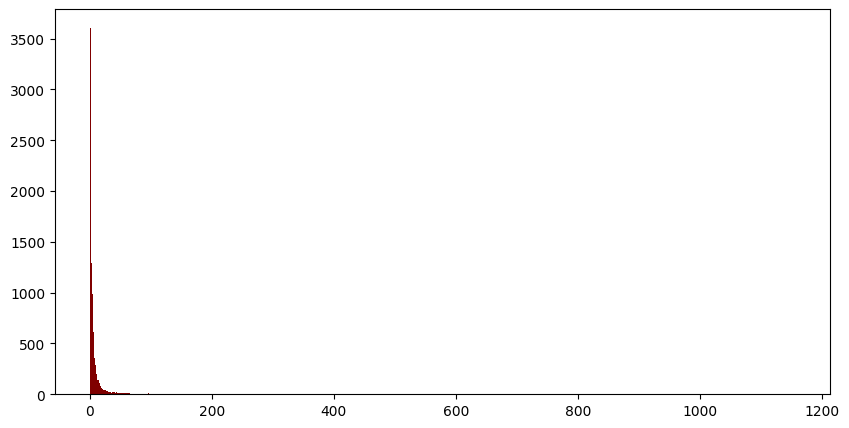

In [43]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
count_UID = group_review.groupby('UID').agg({'UID':'count'}).rename(columns={'UID':'count'}).reset_index()
plt.bar(count_UID['UID'], count_UID['count'], color ='maroon', width = 1)
plt.show()

### 1.3.4 clean

In [45]:
def concat_with_column_name(row):
    concatenated_values = []
    for col, val in row.items():
        if pd.notnull(val):
            convert_value = lambda vals: [f"{col}_{v.strip()}" for v in vals.split(',')if v.strip() != '']
            value = '|'.join(convert_value(val) if isinstance(val, str) else [f"{col}_{val}"])
            if value:
                concatenated_values.append(value)
    return '|'.join(concatenated_values)

In [46]:
product_feature['tag'] = ''
product_feature['tag'] = product_feature.drop(columns=['ID', 'RE_ID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)
user_feature['tag'] = ''
user_feature['tag'] = user_feature.drop(columns=['ID', 'RE_ID']).progress_apply(lambda row: concat_with_column_name(row), axis=1)

 18%|█▊        | 5387/30698 [00:00<00:00, 53868.77it/s]

100%|██████████| 107321/107321 [00:04<00:00, 25837.60it/s]


## 1.4 Example data

In [47]:
from IPython.display import display ,HTML

review_filtered_html = f"<h3>review_filtered</h3>\n{review_filtered.head().to_html(index=False)}"
product_feature_html = f"<h3>product_feature</h3>\n{product_feature[['ID', 'tag']].head().to_html(index=False)}"
user_feature_html = f"<h3>user_feature</h3>\n{user_feature[['ID', 'tag']].head().to_html(index=False)}"

# Combine HTML for side-by-side display
html_combined = f"<div style='display: inline-block; margin-right: 20px;'>{review_filtered_html}</div>" \
                f"<div style='display: inline-block;'>{product_feature_html}</div>" \
                f"<div style='display: inline-block; margin-right: 20px;'>{user_feature_html}</div>"

# Display the HTML
display(HTML(html_combined))

# 2. recommender with LightFM

## 2.1 Import libraries

In [48]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k
from lightfm.evaluation import auc_score as lightfm_auc_score

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]
LightFM version: 1.17


## 2.2 Defining variables

In [49]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 200
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [50]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [51]:
dataset.fit(users=review_filtered['userID'], 
            items=review_filtered['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 14282, num_topics: 7451.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [55]:
(interactions, weights) = dataset.build_interactions(review_filtered.iloc[:, 2:0:-1].values)

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [56]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

Double check the size of both the train and test sets.

In [57]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (14282, 7451)
Shape of test interactions: (14282, 7451)


### 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [58]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))

The LightFM model can be fitted with the following code:

In [59]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS, verbose=True);

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


### 2.5 Prepare model evaluation data

Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [60]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [61]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [62]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

100%|██████████| 33295/33295 [00:01<00:00, 20096.99it/s]

Took 9.8 seconds for prepare and predict test data.


And samples of the test dataframe:

In [63]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
30229,4212,4718,1.0
5910,46126,13922,1.0
26773,81889,25692,1.0
7063,37114,19208,1.0
7653,28978,22274,1.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [27]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(review_filtered, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

prepare all predictions


100%|██████████| 5625/5625 [00:00<00:00, 8664.57it/s]


map ratings


100%|█████████▉| 29361818/29362500 [20:07<00:00, 23566.27it/s]

: 

Samples of the `all_predictions` dataframe:

In [ ]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
471550,626,1058,79.402306
373280,474,1564,-32.299191
1271323,75,1452,-104.067802
310738,352,1381,-111.917725
1323612,68,1584,-29.134760


Note that the **raw prediction values from the LightFM model are for ranking purposes only**, they should not be used directly. The magnitude and sign of these values do not have any specific interpretation.

### 2.6 Model evaluation

Once the evaluation data are ready, they can be passed into to the repo's evaluation methods as follows. The performance of the model will be tracked using both Precision@K and Recall@K.

In addition, the results have also being compared with those computed from LightFM's own evaluation methods to ensure accuracy.

In [ ]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, train_interactions, k=K).mean()
eval_auc_lfm = lightfm_auc_score(model1, test_interactions, train_interactions).mean()
time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    f"time:\t{time_reco3:.3f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    f"time:\t{time_lfm:.3f}",
    f"Recall@K:\t{eval_auc_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056
time:	5.312

------ Using LightFM evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056
time:	0.490


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [ ]:
# split the genre based on the separator
movie_genre = [x.split('|') for x in data['genre']]

In [ ]:
# retrieve the all the unique genres in the data
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Retrieve and prepare movie genres

Further user features can be included as part of the model fitting process. In this notebook, **only the occupation of each user will be included** but the feature list can be extended easily.


#### 3.2.1 Retrieve and merge data

The user features can be retrieved directly from the grouplens website and merged with the existing data as follows:

In [ ]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
columns = ['userID','age','gender','occupation','zipcode']
user_data = pd.read_table(user_feature_URL, sep='|', header=None, names=columns)

# merging user feature with existing data
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
# quick look at the merged data
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation
75721,455,402,4.0,Comedy|Romance|Thriller,administrator
80184,746,161,3.0,Action|Romance,engineer
19864,268,12,4.0,Crime|Thriller,engineer
76699,600,1004,4.0,Drama|Western,programmer
92991,396,125,3.0,Drama|Romance,engineer


#### 3.2.2 Extract and prepare user occupations

In [ ]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(new_data['occupation'])))

### 3.3 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [ ]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [ ]:
item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [ ]:
user_features = dataset2.build_user_features((x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [ ]:
interactions2, weights2 = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

### 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [ ]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

The LightFM model can then be fitted:

In [ ]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS
           )

### 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, 
    interactions2.col, 
    interactions2.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

The test dataframe is then constructed as follows:

In [ ]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

100%|██████████| 25000/25000 [00:01<00:00, 18637.98it/s]

Took 2.4 seconds for prepare and predict test data.


The predictions of all unseen user-item pairs can be prepared as follows:

In [ ]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

100%|██████████| 1511126/1511126 [17:22<00:00, 1449.00it/s]

Took 1118.6 seconds for prepare and predict all data.


### 3.5 Model evaluation and comparison

The predictive performance of the new model can be computed and compared with the previous model (which used only the explicit rating) as follows:

In [ ]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using both implicit and explicit ratings ------
Precision@K:	0.143372
Recall@K:	0.051515


The new model which used both implicit and explicit data performed consistently better than the previous model which used only the explicit data, thus highlighting the benefits of including such additional features to the model.

### 3.6 Evaluation metrics comparison

Note that the evaluation approaches here are solely for demonstration purposes only.

If the reader were using the LightFM package and/or its models, the LightFM's built-in evaluation methods are much more efficient and are the recommended approach for production usage as they are designed and optimised to work with the package. If the reader wants to compare LigthFM with other algorithms in Recommenders repository, it is better to use the evaluation tools in Recommenders.

As a comparison, the times recorded to evaluate model1 are shown as follows:

In [ ]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Time [sec]:\t{time_lfm:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	1475.0

------ Using LightFM evaluation methods ------
Time [sec]:	0.5


## 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first model (using only explicit data), the model fitting progress is shown as follows:

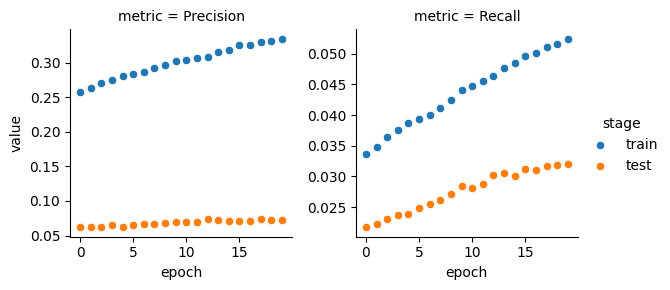

In [ ]:
output1, _ = track_model_metrics(model=model1, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS)

The second model (with both implicit and explicit data) fitting progress:

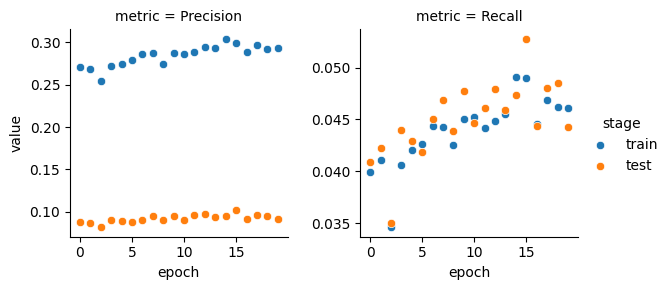

In [ ]:
output2, _ = track_model_metrics(model=model2, 
                                 train_interactions=train_interactions2, 
                                 test_interactions=test_interactions2, 
                                 k=K,                              
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS, 
                                 item_features=item_features,
                                 user_features=user_features)

These show slightly different behaviour with the two approaches, the reader can then tune the hyperparameters to improve the model fitting process.


### 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

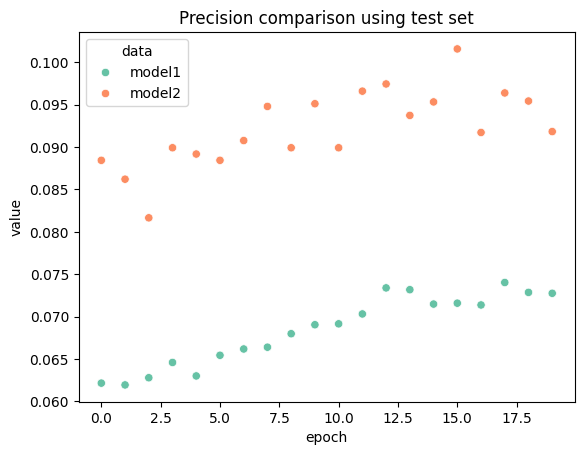

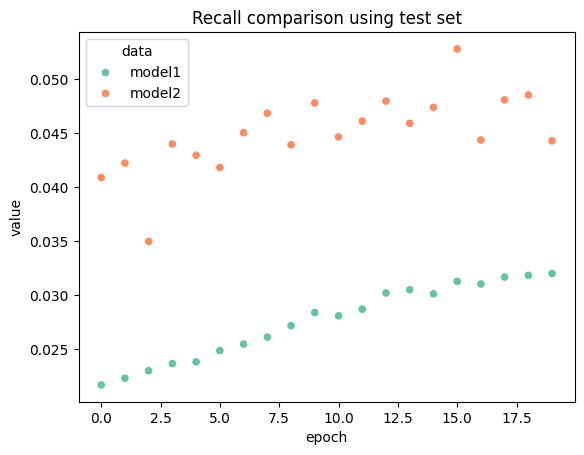

In [ ]:
for i in ['Precision', 'Recall', 'AUC']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", 
                    y="value", 
                    hue='data',
                    data=compare_metric(df_list = [output1, output2], metric=i)
                   ).set_title(f'{i} comparison using test set');

In [ ]:
auc_score_1 = lightfm_auc_score( 
        model1, test_interactions, train_interactions,
        num_threads=8).mean()

auc_score_2 = lightfm_auc_score( 
        model2, test_interactions2, train_interactions2, user_features=user_features, item_features=item_features, 
        num_threads=8).mean()

In [ ]:
auc_score_1, auc_score_2

(0.84126884, 0.86115015)

Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised. Reader can decide on the number of epochs and other hyperparameters to adjust suit the application.

As stated previously, it is interesting to see model2 (using both implicit and explicit data) performed consistently better than model1 (using only explicit ratings). 

## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [ ]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-0.21063931, -1.1855344 ,  1.7477101 , ...,  2.956625  ,
        -2.4791205 ,  3.6644025 ],
       [-0.75674057,  0.7742681 ,  2.8317728 , ...,  3.6863408 ,
        -4.324531  ,  4.1035767 ],
       [-0.22949821,  2.1204798 ,  1.3568478 , ...,  1.0313106 ,
        -5.474852  ,  4.5991907 ],
       ...,
       [ 1.6361976 , -1.3406836 ,  2.6016808 , ...,  2.2879155 ,
        -2.5354466 ,  3.3360822 ],
       [-0.7454586 ,  0.77087927,  2.7763193 , ...,  3.6080742 ,
        -4.18906   ,  3.9646206 ],
       [-1.253258  ,  1.5773958 ,  1.9461527 , ...,  3.371489  ,
        -4.010922  ,  4.6178393 ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `recommenders`. For example, if we want to choose top 10 users most similar to the user 1:

In [ ]:
similar_users(user_id=1, 
              user_features=user_features, 
              model=model2)

,userID,score
0,555,0.999999
1,54,0.999998
2,314,0.999995
3,395,0.999994
4,465,0.999994
5,481,0.999994
6,282,0.999993
7,527,0.999993
8,411,0.999992
9,881,0.999986


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [ ]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[ 0.21875654,  0.4265887 ,  0.74579424, ...,  0.83563685,
        -1.1177105 ,  0.9383874 ],
       [ 0.16888407,  0.47610795,  0.86247116, ...,  1.0432467 ,
        -1.0398555 ,  1.0684679 ],
       [ 0.1448543 ,  0.59444225,  0.8099842 , ...,  0.81349605,
        -1.0454067 ,  0.84652305],
       ...,
       [ 0.2720778 ,  0.02725954,  0.2605585 , ...,  0.2989042 ,
        -0.40973735,  0.23907483],
       [-0.55318254, -0.41106042,  0.5032477 , ...,  1.1808646 ,
        -0.6489976 ,  0.91652644],
       [-0.26365614, -0.27856615,  0.8784231 , ...,  0.7883837 ,
        -0.75104433,  0.83417124]], dtype=float32)

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [ ]:
similar_items(item_id=10, 
              item_features=item_features, 
              model=model2)

,itemID,score
0,417,0.999497
1,373,0.999292
2,12,0.999131
3,231,0.999130
4,182,0.999119
5,474,0.999111
6,76,0.999083
7,253,0.999078
8,573,0.999045
9,296,0.999031


In [ ]:
# Record results for tests - ignore this cell
store_metadata("eval_precision", eval_precision)
store_metadata("eval_recall", eval_recall)
store_metadata("eval_precision2", eval_precision2)
store_metadata("eval_recall2", eval_recall2)
